# experiments on k-class hierarchy classification

In [334]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import torch
from torch.nn import functional
import copy
import matplotlib.pyplot as plt
import os
import json
from core.GMC import GMC
import h5py
import cv2
from utils.utils import eval, plot_result, eval2
from sklearn.model_selection import train_test_split

Our goal:
$\mathbb{E}[g(o(x))(\sum_{v}(\mathbb{1}_{q(v)>\lambda(x)}y)]-\sigma)\leq \alpha$


In [335]:
sigma = 0.95
alpha = 0.025

In [336]:
data_path = os.path.join(os.getcwd(), '..\datasets\HierClass\Result')

In [337]:
# label_dict: label:label_name
# slot2value: father:child list
# depth_dict: label:depth
# depth2label: depth:label list
# value2slot: child:father
def get_depth(value2slot, x):
    depth = 0
    while value2slot[x] != -1:
        depth += 1
        x = value2slot[x]
    return depth

label_dict = torch.load(os.path.join(data_path, 'value_dict.pt'))
label_dict = {i: v for i, v in label_dict.items()}

slot2value = torch.load(os.path.join(data_path, 'slot.pt'))
value2slot = {}
num_class = 0
for s in slot2value:
    for v in slot2value[s]:
        value2slot[v] = s
        if num_class < v:
            num_class = v
num_class += 1
path_list = [(i, v) for v, i in value2slot.items()]
for i in range(num_class):
    if i not in value2slot:
        value2slot[i] = -1

depth_dict = {i: get_depth(value2slot, i) for i in range(num_class)}
max_depth = depth_dict[max(depth_dict, key=depth_dict.get)] + 1
depth2label = {i: [a for a in depth_dict if depth_dict[a] == i] for i in range(max_depth)}

In [338]:
def nearest_common_ancestor(x,y):
    if x==y:
        return x
    elif value2slot[x]==value2slot[y]:
        return value2slot[x]
    else:
        return 141 #141 stands for root

def get_r(h):
    g = np.ones((h.shape[0], h.shape[1]+1))
    g[:, :h.shape[1]] = copy.deepcopy(h)
    for i in range(7):
        g[:,i] = np.sum(h[:,list(slot2value[i])], axis=-1)
    g[:,141] = np.sum(g[:,:7], axis=-1)
    return g

f = h5py.File(os.path.join(data_path, 'result.h'), 'r')
h = f['h'][:,1,:]
# turn h into [0,1]
h = torch.softmax(torch.Tensor(h), dim=-1).numpy()
h += np.random.uniform(-0.005, 0.005, h.shape)
f2 = h5py.File(os.path.join(data_path, 'label.h'), 'r')
y = np.argmax(f2['y'][:, -141:],axis=-1)
u = np.argmax(h, axis=-1)
leaf_h = np.max(h, axis=-1)
print('shape of h: ', h.shape)
print('shape of y: ', y.shape)
print('shape of u: ', u.shape)
print('shape of leaf_h: ', leaf_h.shape)
r = get_r(h)
print('shape of r: ', r.shape)
for i in range(h.shape[0]):
    for v in range(7,141):
        h[i,v]=r[i,nearest_common_ancestor(u[i],v)]
processed_h = h[:, :141]
ancestor = np.ones((h.shape[0],3))
ancestor_r = np.ones((h.shape[0],3))
for i in range(h.shape[0]):
    ancestor[i,:] = np.array([u[i], value2slot[u[i]], 141])
    ancestor_r[i,:] = np.array([r[i,u[i]], r[i,value2slot[u[i]]],r[i,141]])
ancestor_info = np.concatenate([ancestor, ancestor_r], axis=-1)
print(ancestor_info.shape)
ancestor_cal, ancestor_test, h_cal, h_test, y_cal, y_test, leaf_h_cal, leaf_h_test = train_test_split(ancestor_info, processed_h, y, leaf_h, test_size=0.3, random_state=45) 

shape of h:  (9397, 141)
shape of y:  (9397,)
shape of u:  (9397,)
shape of leaf_h:  (9397,)
shape of r:  (9397, 142)
(9397, 6)


In [339]:
def generate_G():
    G = []
    G.append(lambda x:(x>=0).astype('int64'))
    G.append(lambda x:((x==0)+(x==99)+(x==101)+(x==37)+(x==7)+(x==41)+(x==12)+(x==140)+(x==46)+(x==110)+(x==111)+(x==49)+(x==50)+(x==23)+(x==57)+(x==91)+(x==28)+(x==125)).astype('int64'))
    G.append(lambda x:((x==1)+(x==128)+(x==129)+(x==131)+(x==132)+(x==134)+(x==135)+(x==8)+(x==138)+(x==11)+(x==139)+(x==16)+(x==19)+(x==21)+(x==22)+(x==27)+(x==35)+(x==36)+(x==38)+(x==39)+(x==40)+(x==43)+(x==44)+(x==47)+(x==52)+(x==53)+(x==54)+(x==63)+(x==65)+(x==68)+(x==69)+(x==70)+(x==72)+(x==73)+(x==74)+(x==75)+(x==76)+(x==78)+(x==80)+(x==85)+(x==89)+(x==106)+(x==107)+(x==108)+(x==109)+(x==112)+(x==114)+(x==115)+(x==116)+(x==117)+(x==121)+(x==124)+(x==126)+(x==127)).astype('int64'))
    G.append(lambda x:((x==2)+(x==33)+(x==66)+(x==71)+(x==9)+(x==45)+(x==82)+(x==51)+(x==83)+(x==118)+(x==56)+(x==120)).astype('int64'))
    G.append(lambda x:((x==3)+(x==98)+(x==58)+(x==102)+(x==103)+(x==10)+(x==79)+(x==113)+(x==84)+(x==55)+(x==24)+(x==90)+(x==59)+(x==60)+(x==29)+(x==62)+(x==95)).astype('int64'))
    G.append(lambda x:((x==4)+(x==32)+(x==42)+(x==13)+(x==17)+(x==18)+(x==20)+(x==25)+(x==26)+(x==31)).astype('int64'))
    G.append(lambda x:((x==5)+(x==34)+(x==67)+(x==77)+(x==14)+(x==48)+(x==81)+(x==92)+(x==61)+(x==94)).astype('int64'))
    G.append(lambda x:((x==6)+(x==130)+(x==133)+(x==136)+(x==137)+(x==15)+(x==30)+(x==64)+(x==86)+(x==87)+(x==88)+(x==93)+(x==96)+(x==97)+(x==100)+(x==104)+(x==105)+(x==119)+(x==122)+(x==123)).astype('int64'))
    G.append(lambda x:-(x>=0).astype('int64'))
    G.append(lambda x:-((x==0)+(x==99)+(x==101)+(x==37)+(x==7)+(x==41)+(x==12)+(x==140)+(x==46)+(x==110)+(x==111)+(x==49)+(x==50)+(x==23)+(x==57)+(x==91)+(x==28)+(x==125)).astype('int64'))
    G.append(lambda x:-((x==1)+(x==128)+(x==129)+(x==131)+(x==132)+(x==134)+(x==135)+(x==8)+(x==138)+(x==11)+(x==139)+(x==16)+(x==19)+(x==21)+(x==22)+(x==27)+(x==35)+(x==36)+(x==38)+(x==39)+(x==40)+(x==43)+(x==44)+(x==47)+(x==52)+(x==53)+(x==54)+(x==63)+(x==65)+(x==68)+(x==69)+(x==70)+(x==72)+(x==73)+(x==74)+(x==75)+(x==76)+(x==78)+(x==80)+(x==85)+(x==89)+(x==106)+(x==107)+(x==108)+(x==109)+(x==112)+(x==114)+(x==115)+(x==116)+(x==117)+(x==121)+(x==124)+(x==126)+(x==127)).astype('int64'))
    G.append(lambda x:-((x==2)+(x==33)+(x==66)+(x==71)+(x==9)+(x==45)+(x==82)+(x==51)+(x==83)+(x==118)+(x==56)+(x==120)).astype('int64'))
    G.append(lambda x:((x==3)+(x==98)+(x==58)+(x==102)+(x==103)+(x==10)+(x==79)+(x==113)+(x==84)+(x==55)+(x==24)+(x==90)+(x==59)+(x==60)+(x==29)+(x==62)+(x==95)).astype('int64'))
    G.append(lambda x:-((x==4)+(x==32)+(x==42)+(x==13)+(x==17)+(x==18)+(x==20)+(x==25)+(x==26)+(x==31)).astype('int64'))
    G.append(lambda x:-((x==5)+(x==34)+(x==67)+(x==77)+(x==14)+(x==48)+(x==81)+(x==92)+(x==61)+(x==94)).astype('int64'))
    G.append(lambda x:-((x==6)+(x==130)+(x==133)+(x==136)+(x==137)+(x==15)+(x==30)+(x==64)+(x==86)+(x==87)+(x==88)+(x==93)+(x==96)+(x==97)+(x==100)+(x==104)+(x==105)+(x==119)+(x==122)+(x==123)).astype('int64'))
    return G
G = generate_G()

In [340]:
def GMC(alpha, eta, x_cal, y_cal, h_cal, x_test, h_test, s, group_G, f=(lambda x:0), f_test = (lambda x:0), T=500, proj=None):
    fx = f(x_cal)
    fx_test = f_test(x_test)
    n = x_cal.shape[0]
    n2 = x_test.shape[0]
    for i in range(T):
        update = False
        output = (x_cal[:,3:]<fx[:,None].repeat(3, axis=-1)).astype('int64')
        output[:,1:] -= output[:,2:]
        output = np.sum(output*x_cal[:,:3], axis=-1)
        for g in group_G:
            #print(g(output)@s(fx, x_cal, y_cal, h_cal))
            if g(output)@s(fx, x_cal, y_cal, h_cal)>alpha*n:
                update = True
                print(group_G.index(g), g(output)@s(fx, x_cal, y_cal, h_cal)/n)
                break
        if update==False:
            print(i)
            print('end')
            break
        else:
            output_test = (x_test[:,3:]<fx_test[:,None].repeat(3, axis=-1)).astype('int64')
            output_test[:,1:] -= output_test[:,2:]
            output_test = np.sum(output_test*x_test[:,3:], axis=-1)
            fx = fx - eta*g(output)
            fx_test = fx_test - eta*g(output_test)
            if not (proj is None):
                fx = proj(fx)
                fx_test = proj(fx_test)
    return fx, fx_test

def s(lamda, x, y, h):
    shape2 = h.shape[1]
    lamda = lamda[:,None].repeat(shape2,axis=1)
    intersect = (h<lamda).astype('int64')[[i for i in range(h.shape[0])], y]
    return intersect-sigma

eta = 0.0001
fx, fx_test = GMC(3*alpha/4, eta, ancestor_cal, y_cal, h_cal, ancestor_test, h_test, s, G, f=(lambda x:np.ones(ancestor_cal.shape[0])),f_test=(lambda x:np.ones(ancestor_test.shape[0])),T=400)

8 0.18808727383305596
8 0.18413410369469502
8 0.17958035578531378
8 0.1728979778014305
8 0.16697582484415513
8 0.1607571841265026
8 0.15452333890831796
8 0.14967310323855967
8 0.14344686027064107
8 0.13935684962749065
8 0.13434696670214466
8 0.13100197658506996
8 0.125992093659724
8 0.12280675079823694
8 0.11824540063858958
8 0.1124752926866357
8 0.10837007754295307
8 0.10274441234605468
8 0.09742283715979942
8 0.09179717196290102
8 0.08633115402159028
8 0.0813212710962443
8 0.07691956819218462
8 0.0725102630378589
8 0.0687091379048195
8 0.06369165272920749
8 0.05913030256956022
8 0.05487304242055613
8 0.05062338452181813
8 0.04621407936749246
8 0.04104454918655893
8 0.037547514064162735
8 0.03420252394708811
8 0.029793218792762456
8 0.026296183670366277
8 0.022038923521362226
8 0.01899802341493077
9 0.030234149308195193
9 0.026433024175155823
9 0.0232248745628706
9 0.019279306674775742
41
end


baseline0: output leaf nodes

In [341]:
fx_b0 , fx_test_b0 = leaf_h_cal+1e-5, leaf_h_test+1e-5

baseline1: conformal

In [342]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1) ) >= alpha) - 1, 0) # Can't be -1.
    return lambdas[lhat_idx]
lambda_table = np.linspace(0.75,1.25,100)
calib_losses = np.array([s(np.ones(ancestor_cal.shape[0])*lhat, ancestor_cal, y_cal, h_cal) for lhat in lambda_table]).transpose(1,0)
lhat = get_lhat(calib_losses, lambda_table, alpha)
fx_b, fx_test_b = np.ones(ancestor_cal.shape[0])*lhat, np.ones(y_test.shape[0])*lhat

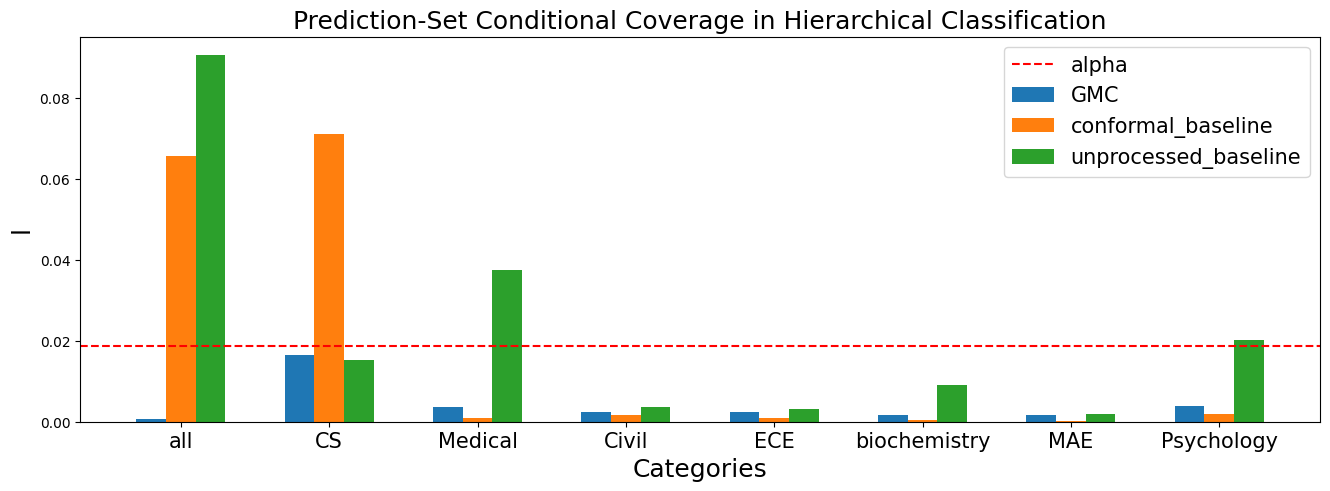

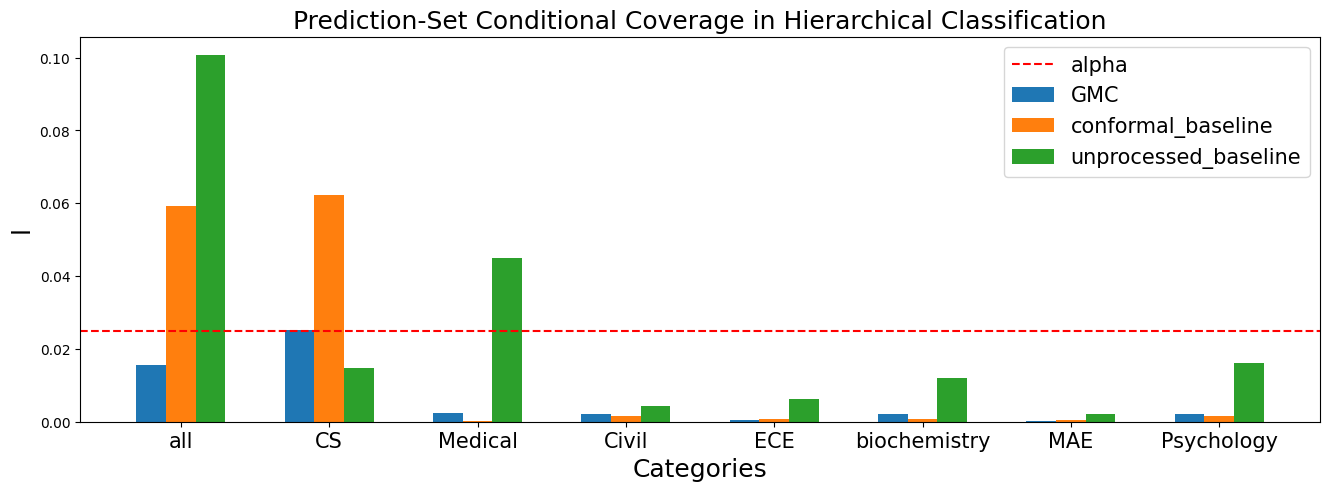

In [343]:
selected_G = G[:8]
def eval(G, s, fx, x, y, h):
    S = []
    n = x.shape[0]
    output = (x[:,3:]<fx[:,None].repeat(3, axis=-1)).astype('int64')
    output[:,1:] -= output[:,2:]
    output = np.sum(output*x[:,:3], axis=-1)
    for g in G:
        S.append(g(output)@s(fx,x,y,h)/n)
    return np.array(S)


category = ['all'] + list(label_dict.values())[:7]
# category = ['all', 'average size', 'bigger size', 'smaller size']
cal_result = eval(selected_G, s, fx, ancestor_cal, y_cal, h_cal)
cal_result_b = eval(selected_G, s, fx_b, ancestor_cal, y_cal, h_cal)
cal_result_b0 = eval(selected_G, s, fx_b0, ancestor_cal, y_cal, h_cal)
test_result = eval(selected_G, s, fx_test, ancestor_test, y_test, h_test)
test_result_b = eval(selected_G, s, fx_test_b, ancestor_test, y_test, h_test)
test_result_b0 = eval(selected_G, s, fx_test_b0, ancestor_test, y_test, h_test)

plot_result(category, np.abs(cal_result), np.abs(cal_result_b), np.abs(cal_result_b0), 'Categories', 'l', 'Prediction-Set Conditional Coverage in Hierarchical Classification',alpha*3/4)
plot_result(category, np.abs(test_result), np.abs(test_result_b), np.abs(test_result_b0), 'Categories', 'l', 'Prediction-Set Conditional Coverage in Hierarchical Classification',alpha)